# Demo/Tutorial for uncertainty_utils.py
This script is to demonstrate how to use uncertainty interface.
Please be aware that you need to have results first generated by inference as demonstrated in the respective notebooks.
In this specific case, we use the results from the journal paper, where we have four different models, each trained under different conditions (end-to-end vs. hybrid, compact vs. large).

## Checking GPU Availability
First, let's see if we have a GPU available. It is highly recommended to utilize a GPU, although it is also possible to run this experiment on the CPU at a much slower rate.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from experiment import *
from experiment_config import *
from loss_utils import getMSELoss
from data_utils import get_result_path, load_results
from uncertainty_utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using " + str(device) + " for evaluation...")

using cuda for evaluation...


## Plotting function
This function plots the uncertainty estimates and the mean squared errors next to each other for comparison.

In [18]:
def plot_ucrt_mse_comparison(ucrt_frame, mse_frame, columns, styles):
    snr_val_list = ["70", "60", "50", "40", "30", "20", "10", "0", "-10", "-20"]
    snr_val_list.reverse()

    SMALL_SIZE = 18
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 32

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    #plt.rc('legend', ncol=2)
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    params = {'legend.fontsize': SMALL_SIZE,
              'legend.handlelength': 1}
    plt.rcParams.update(params)

    num_methods = mse_frame.shape[2]
    ucrt_results = pd.DataFrame(np.reshape(ucrt_frame, (10,num_methods)), columns=columns)
    mse_results = pd.DataFrame(np.reshape(mse_frame, (10,num_methods)), columns=columns)

    fig, axes = plt.subplots(figsize=(20, 9), nrows=1, ncols=2)

    markersize = 12
    idx = 0
    subax = ucrt_results.plot(ax=axes[idx], style=styles, linewidth=2.0, ms=10, legend=False, title='', sharex=True)
    subax.set_xticklabels(snr_val_list, rotation=0)
    subax.set_ylabel('Uncertainty')
    subax.set_xlabel('SNR')


    idx = 1
    subax = mse_results.plot(ax=axes[idx], style=styles, linewidth=2.0, ms=10, legend=True, title='', sharex=True)

    subax.set_xticklabels(snr_val_list, rotation=0)
    subax.set_ylabel('MSE')
    subax.set_xlabel('SNR')
    #plt.ylim((0.00, 0.018))
    plt.legend(loc='best', bbox_to_anchor=(1., 0.55))
    plt.legend(handlelength=3, ncol=2)

    plt.plot()
    plt.tight_layout()
    #plt.savefig("ucrt_and_mse_vs_SNR.png", dpi=fig.dpi)


## Defining Locations of Ground Truth Masks and Results

In [2]:
mask_dir = os.path.join(os.getcwd(), 'data', 'masks', 'test')
hybrid_input_path = os.path.join(os.getcwd(), 'data', 'hybrid', 'test')
e2e_input_path = os.path.join(os.getcwd(), 'data', 'end2end', 'test')

In [3]:
lrg_hybrid_model_file = os.path.join(os.getcwd(), 'data', 'hybrid', 'models', 'lrg', '80k',
                                     '2020-4-25_15-5-29.503889', 'models', 'best_model.pth')
lrg_hybrid_results_path = get_result_path(lrg_hybrid_model_file, hybrid_input_path)
lrg_hybrid_results = load_results(lrg_hybrid_results_path, mask_dir, getHybridPrefixes())

cmp_hybrid_model_file = os.path.join(os.getcwd(), 'data', 'hybrid', 'models', 'cmp', '80k',
                                     '2020-4-25_13-32-31.889297', 'models', 'best_model.pth')
cmp_hybrid_results_path = get_result_path(cmp_hybrid_model_file, hybrid_input_path)
cmp_hybrid_results = load_results(cmp_hybrid_results_path, mask_dir, getHybridPrefixes())

lrg_e2e_model_file = os.path.join(os.getcwd(), 'data', 'end2end', 'models', 'lrg', '80k',
                                     '2020-4-17_13-0-34.508471', 'models', 'best_model.pth')
lrg_e2e_results_path = get_result_path(lrg_e2e_model_file, e2e_input_path)
lrg_e2e_results = load_results(lrg_e2e_results_path, mask_dir, getE2EPrefixes())

cmp_e2e_model_file = os.path.join(os.getcwd(), 'data', 'end2end', 'models', 'cmp', '80k',
                                     '2020-4-17_13-17-24.661566', 'models', 'best_model.pth')
cmp_e2e_results_path = get_result_path(cmp_e2e_model_file, e2e_input_path)
cmp_e2e_results = load_results(cmp_e2e_results_path, mask_dir, getE2EPrefixes())

## Loading Results and Computing UCRT1 and MSE
More uncertainty estimation methods are available in `uncertainty_utils.py`.

In [4]:
snr_list = ["SNR_70", "SNR_60", "SNR_50", "SNR_40", "SNR_30", "SNR_20", "SNR_10", "SNR_0", "SNR_-10", "SNR_-20"]
snr_list.reverse()

results_template = np.zeros((len(snr_list),1))

all_lrg_hybrid_mse_results = np.zeros((results_template.shape))
all_cmp_hybrid_mse_results = np.zeros((results_template.shape))
all_lrg_e2e_mse_results = np.zeros((results_template.shape))
all_cmp_e2e_mse_results = np.zeros((results_template.shape))

all_lrg_hybrid_ucrt1_results = np.zeros((results_template.shape))
all_cmp_hybrid_ucrt1_results = np.zeros((results_template.shape))
all_lrg_e2e_ucrt1_results = np.zeros((results_template.shape))
all_cmp_e2e_ucrt1_results = np.zeros((results_template.shape))


all_test_results = np.zeros((results_template.shape))


i=0
for snr in snr_list:
    print("loading lrg_hybrid_results: " + str(snr))
    dataset = lrg_hybrid_results[snr]    
    all_lrg_hybrid_mse_results[i] = np.mean(getMSELosses(dataset))
    all_lrg_hybrid_ucrt1_results[i] = np.mean(getUCRT1(dataset))

    print("loading lrg_e2e_results: " + str(snr))
    dataset = lrg_e2e_results[snr]    
    all_lrg_e2e_mse_results[i] = np.mean(getMSELosses(dataset))
    all_lrg_e2e_ucrt1_results[i] = np.mean(getUCRT1(dataset))
    
    print("loading cmp_hybrid_results: " + str(snr))
    dataset = cmp_hybrid_results[snr]    
    all_cmp_hybrid_mse_results[i] = np.mean(getMSELosses(dataset))
    all_cmp_hybrid_ucrt1_results[i] = np.mean(getUCRT1(dataset))

    print("loading cmp_e2e_results: " + str(snr))
    dataset = cmp_e2e_results[snr]    
    all_cmp_e2e_mse_results[i] = np.mean(getMSELosses(dataset))
    all_cmp_e2e_ucrt1_results[i] = np.mean(getUCRT1(dataset))
    
    i+=1
    


loading lrg_hybrid_results: SNR_-20
loading lrg_e2e_results: SNR_-20
loading cmp_hybrid_results: SNR_-20
loading cmp_e2e_results: SNR_-20
loading lrg_hybrid_results: SNR_-10
loading lrg_e2e_results: SNR_-10
loading cmp_hybrid_results: SNR_-10
loading cmp_e2e_results: SNR_-10
loading lrg_hybrid_results: SNR_0
loading lrg_e2e_results: SNR_0
loading cmp_hybrid_results: SNR_0
loading cmp_e2e_results: SNR_0
loading lrg_hybrid_results: SNR_10
loading lrg_e2e_results: SNR_10
loading cmp_hybrid_results: SNR_10
loading cmp_e2e_results: SNR_10
loading lrg_hybrid_results: SNR_20
loading lrg_e2e_results: SNR_20
loading cmp_hybrid_results: SNR_20
loading cmp_e2e_results: SNR_20
loading lrg_hybrid_results: SNR_30
loading lrg_e2e_results: SNR_30
loading cmp_hybrid_results: SNR_30
loading cmp_e2e_results: SNR_30
loading lrg_hybrid_results: SNR_40
loading lrg_e2e_results: SNR_40
loading cmp_hybrid_results: SNR_40
loading cmp_e2e_results: SNR_40
loading lrg_hybrid_results: SNR_50
loading lrg_e2e_results

## Plotting uncertainty estimates vs. actual mean squared error (MSE)
As can be seen, there is a high correlation between the uncertainty estimates and the actual MSE.
Even the fact that the end-to-end models are not giving better results (in terms of MSE) from approximately 30 dB SNR upwards is well reflected in the uncertainty estimations.

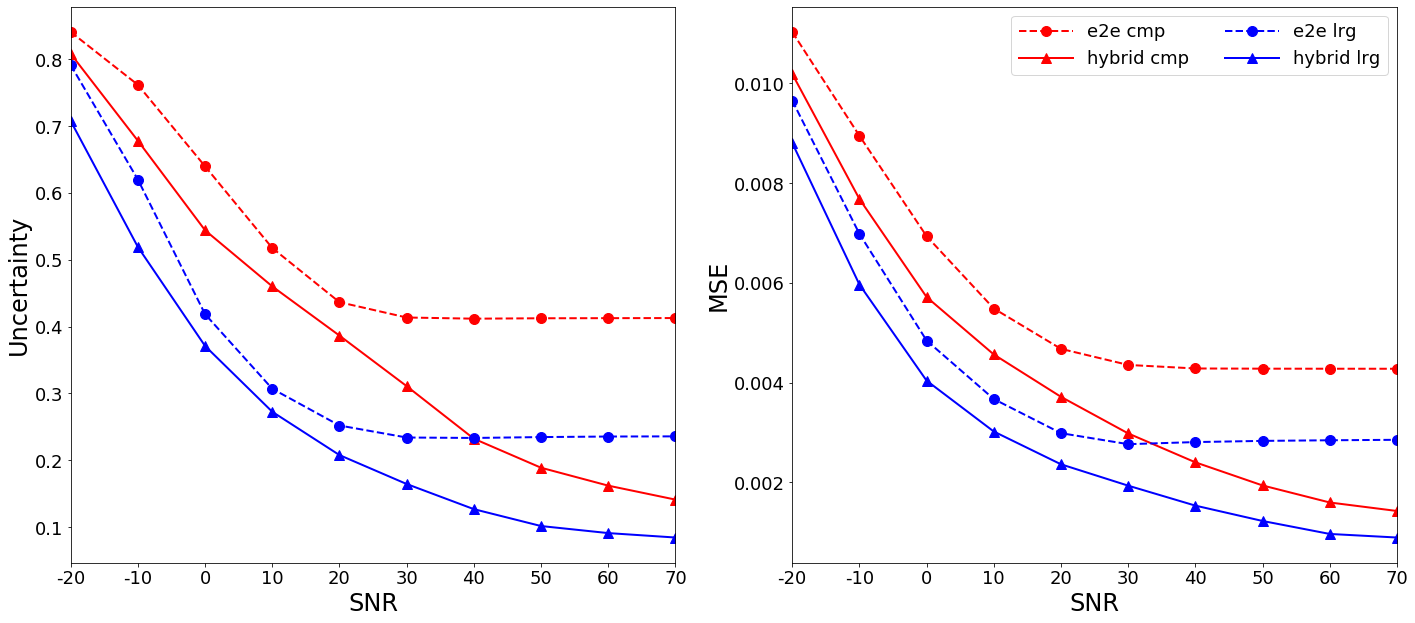

In [19]:
mse_frame = np.transpose(np.concatenate(([all_cmp_e2e_mse_results], [all_cmp_hybrid_mse_results], [all_lrg_e2e_mse_results], [all_lrg_hybrid_mse_results]), axis=0))
ucrt_frame = np.transpose(np.concatenate(([all_cmp_e2e_ucrt1_results], [all_cmp_hybrid_ucrt1_results], [all_lrg_e2e_ucrt1_results], [all_lrg_hybrid_ucrt1_results]), axis=0))
columns = ['e2e cmp', 'hybrid cmp', 'e2e lrg', 'hybrid lrg']
styles = ['ro--','r^-','bo--','b^-']

plot_ucrt_mse_comparison(ucrt_frame, mse_frame, columns, styles)